## 导入python库

In [43]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('default')  # 设置画图的风格
import shap


from EIDG import EIDG
from vehicle_related import Vehicle
from vehicle_related import plot_vehicle
from vehicle_related import calculate_acceleration


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## IDM 模拟车辆跟车过程，并产生数据

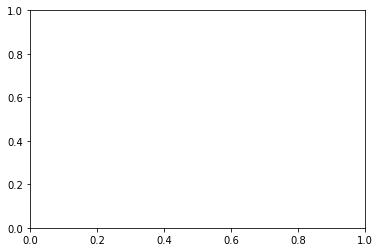

In [44]:

# 创建初始图
fig, ax = plt.subplots()
plt.ion()  # 打开交互模式
# 定义前视范围和后视范围
front_view = 80  # 前视范围，单位：米
rear_view = 80  # 后视范围，单位：米

# 循环调用fcn函数
def plot_vehicle(s1, s2):
    ax.clear()  # 清除前一次迭代的图
    # 计算x轴范围
    x_min = s1 - front_view
    x_max = s1 + rear_view

    # 绘制道路
    road_length = front_view + rear_view  # 道路长度，单位：米
    road_width = 3.5  # 道路宽度，单位：米
    ax.add_patch(plt.Rectangle((x_min, 0), road_length, road_width, edgecolor='k', facecolor='w'))

    # 定义车辆的绝对尺寸
    car_length = 4  # 车辆的长度，单位：米
    car_width = 2  # 车辆的宽度，单位：米

    # 绘制第一辆车
    car1_center = s1  # 第一辆车的质心位置，单位：米
    ax.add_patch(plt.Rectangle((car1_center - car_length / 2, (road_width - car_width) / 2), car_length, car_width,
                               edgecolor='r', facecolor='none'))

    # 绘制第二辆车
    car2_center = s2  # 第二辆车的质心位置，单位：米
    ax.add_patch(plt.Rectangle((car2_center - car_length / 2, (road_width - car_width) / 2), car_length, car_width,
                               edgecolor='b', facecolor='none'))

    # 设置坐标轴
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([0, road_width])

    # 添加标签和标题
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Width (m)')
    ax.set_title('Road with Cars')

    plt.pause(0.2)  # 等待一段时间以便查看图像


# 创建两辆车
car1 = Vehicle(initial_speed=0, initial_position=0)
car2 = Vehicle(initial_speed=10, initial_position=30)

# 模拟时间步长和总模拟时间
time_step = 0.05  # 时间步长（秒）
total_simulation_time = 20  # 总模拟时间（秒）

# 列表用于存储车辆状态
s_list = []
v_list = []
delta_v_list = []
acc_list = []
for t in np.arange(0, total_simulation_time, time_step):
    # 计算两辆车的加速度
    if (car2.position - car1.position) < 4:
        print("crash")
        break

    # plot_vehicle(car1.position, car2.position)

    s = car2.position - car1.position
    v = car1.speed
    delta_v = car1.speed - car2.speed

    car1_acceleration = calculate_acceleration(s, v, delta_v)
    # 更新车辆状态
    car1.update(time_step, car1_acceleration)
    car2.update(time_step, 0)

    # 保存车辆速度和位置
    s_list.append(s)
    v_list.append(v)
    delta_v_list.append(delta_v)
    acc_list.append(car1_acceleration)

# 关闭交互模式
plt.ioff()
plt.show()

In [45]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 假设您已经有了数据 v、s、delta_v 和 a_v
# 假设数据已经通过数据处理和特征工程
s = np.array(s_list)
v = np.array(v_list)
delta_v= np.array(delta_v_list)
# 数据预处理
X = np.column_stack((s, v, delta_v))
y = np.array(acc_list)

##  XGBoost模型训练和归因

### 模型训练

XGBoost R-squared (R2): 0.9938289671487315


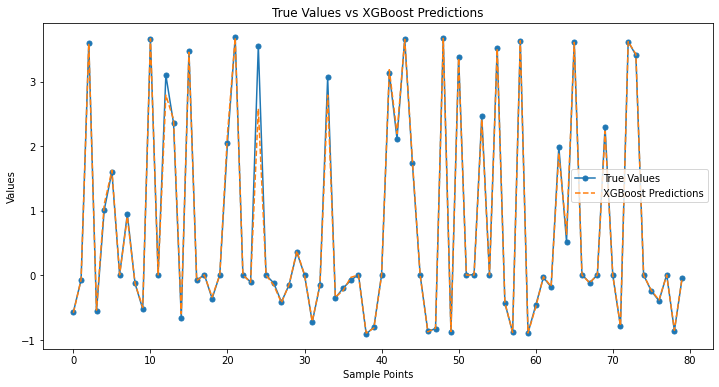

In [46]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用XGBoost进行回归
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train, y_train)

# 计算XGBoost的预测输出
xgb_predictions = xgb_reg.predict(X_test)

# 计算R-squared（R2）来衡量模型准确性
xgb_r2 = r2_score(y_test, xgb_predictions)

print("XGBoost R-squared (R2):", xgb_r2)

# 绘制真实值和XGBoost预测值的曲线对比
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='True Values', marker='o', markersize=5)
plt.plot(range(len(y_test)), xgb_predictions, label='XGBoost Predictions', linestyle='--')
plt.xlabel('Sample Points')
plt.ylabel('Values')
plt.legend()
plt.title('True Values vs XGBoost Predictions')
plt.show()

In [47]:
import joblib
joblib.dump(xgb_reg, 'xgb_regression_model_start.pkl')

['xgb_regression_model_start.pkl']

### 归因（EIDG方法，正定，多基值）

#### 特征归因值计算

In [48]:
from EIDG import EIDG
eidg_instance = EIDG(x_baselines=X_train, model = xgb_reg.predict,steps=50, h=0.1, m=10, pos=True)
explainer_xgb_eidg_values = eidg_instance.integrated_gradients(X_train)

EIDG运行时间： 0.25568580627441406 秒


EIDG运行时间： 0.16076064109802246 秒
EIDG运行时间： 0.09788155555725098 秒
EIDG运行时间： 0.16038298606872559 秒
EIDG运行时间： 0.09617400169372559 秒
EIDG运行时间： 0.10954713821411133 秒


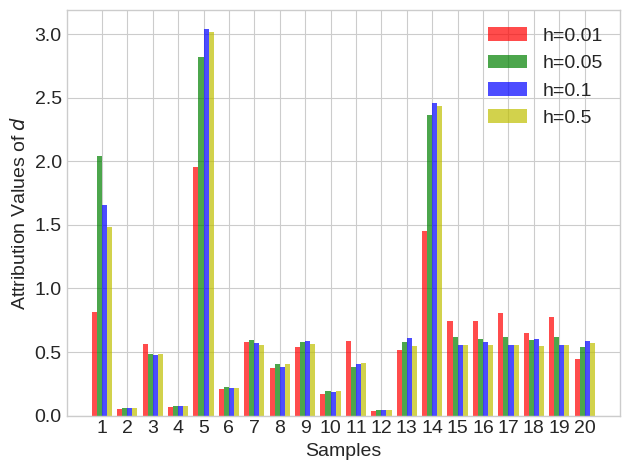

EIDG运行时间： 0.13196396827697754 秒
EIDG运行时间： 0.11461067199707031 秒
EIDG运行时间： 0.18505334854125977 秒
EIDG运行时间： 0.18903803825378418 秒
EIDG运行时间： 0.1487882137298584 秒


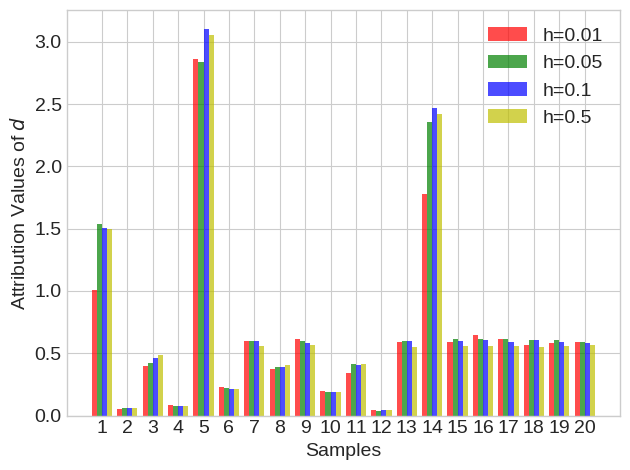

EIDG运行时间： 0.20062685012817383 秒
EIDG运行时间： 0.23736214637756348 秒
EIDG运行时间： 0.22789502143859863 秒
EIDG运行时间： 0.21968317031860352 秒
EIDG运行时间： 0.31249165534973145 秒


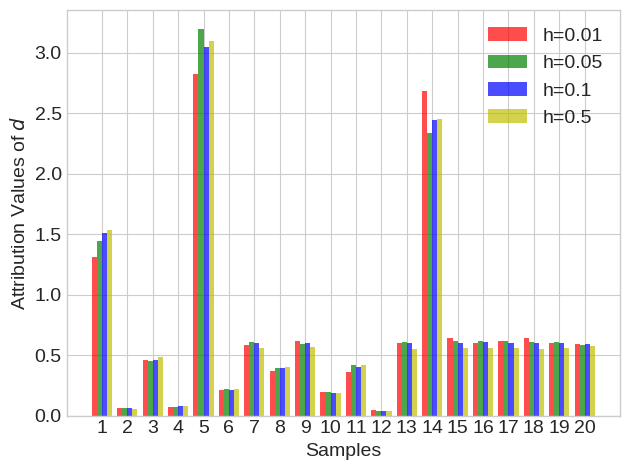

EIDG运行时间： 0.31005430221557617 秒
EIDG运行时间： 0.37207818031311035 秒
EIDG运行时间： 0.33754420280456543 秒
EIDG运行时间： 0.36315131187438965 秒
EIDG运行时间： 0.3379676342010498 秒


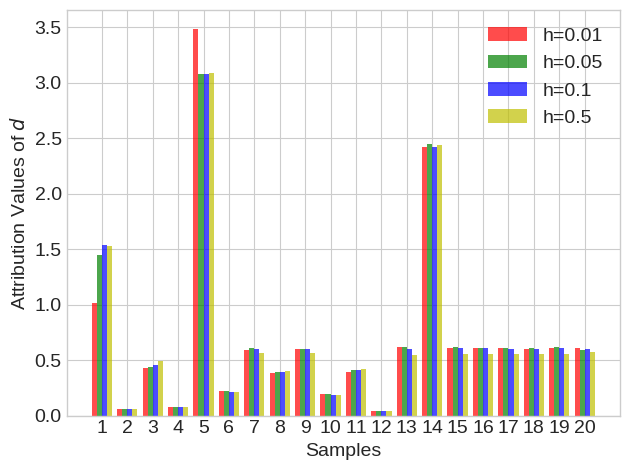

In [87]:
h_list = [0.01,0.05,0.1,0.5,1]
steps = [50, 100, 200, 400]
for step in steps:
    explainer_xgb_eidg_values_list = []
    for h in h_list:
        eidg_instance = EIDG(x_baselines=X_train, model = xgb_reg.predict,steps=step, h=h, m=10, pos=True)
        explainer_xgb_eidg_values = eidg_instance.integrated_gradients(X_train)
        explainer_xgb_eidg_values_list.append(explainer_xgb_eidg_values)
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 生成随机数据
    data = np.random.rand(20, 4)
    
    # 计算每个样本的索引
    index = np.arange(20)
    
    # 绘制直方图
    bar_width = 0.2  # 条形图的宽度
    opacity = 0.7    # 条形图的透明度
    
    plt.bar(index, explainer_xgb_eidg_values_list[0][0][100:120,0], bar_width, alpha=opacity, color='r', label='h=0.01')
    plt.bar(index + bar_width, explainer_xgb_eidg_values_list[1][0][100:120,0], bar_width, alpha=opacity, color='g', label='h=0.05')
    plt.bar(index + 2 * bar_width, explainer_xgb_eidg_values_list[2][0][100:120,0], bar_width, alpha=opacity, color='b', label='h=0.1')
    plt.bar(index + 3 * bar_width, explainer_xgb_eidg_values_list[3][0][100:120,0], bar_width, alpha=opacity, color='y', label='h=0.5')
    
    # 添加图例
    plt.legend(fontsize=14)
    
    # 设置横轴和纵轴标签
    plt.xlabel('Samples', fontsize=14)
    plt.ylabel('Attribution Values of $d$', fontsize=14)
    
    # 设置x轴刻度标签
    plt.xticks(index + 1.5 * bar_width, range(1, 21),fontsize=14)
    plt.yticks(fontsize=14)
    # 显示图形
    plt.tight_layout()
    plt.savefig(f'../figure/numerical_stability_{step}.svg', dpi=600, bbox_inches='tight')
    plt.show()

In [50]:
aaa = explainer_xgb_eidg_values_list[0][0][100:120,0]

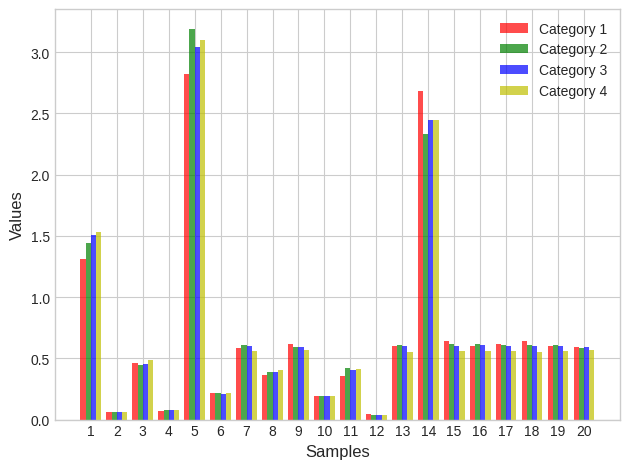

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# 生成随机数据
data = np.random.rand(20, 4)

# 计算每个样本的索引
index = np.arange(20)

# 绘制直方图
bar_width = 0.2  # 条形图的宽度
opacity = 0.7    # 条形图的透明度

plt.bar(index, explainer_xgb_eidg_values_list[0][0][100:120,0], bar_width, alpha=opacity, color='r', label='Category 1')
plt.bar(index + bar_width, explainer_xgb_eidg_values_list[1][0][100:120,0], bar_width, alpha=opacity, color='g', label='Category 2')
plt.bar(index + 2 * bar_width, explainer_xgb_eidg_values_list[2][0][100:120,0], bar_width, alpha=opacity, color='b', label='Category 3')
plt.bar(index + 3 * bar_width, explainer_xgb_eidg_values_list[3][0][100:120,0], bar_width, alpha=opacity, color='y', label='Category 4')

# 添加图例
plt.legend()

# 设置横轴和纵轴标签
plt.xlabel('Samples', fontsize=12)
plt.ylabel('Values', fontsize=12)

# 设置x轴刻度标签
plt.xticks(index + 1.5 * bar_width, range(1, 21))

# 显示图形
plt.tight_layout()
plt.savefig(f'../figure/numerical_stability.svg', dpi=600, bbox_inches='tight')
plt.show()

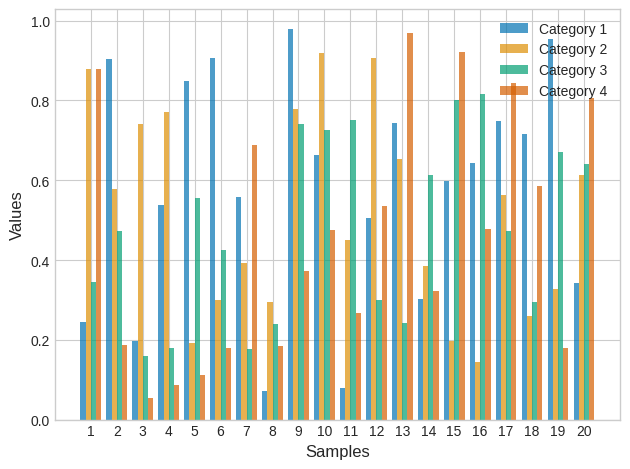

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 设置Nature风格的配色方案
sns.set_palette("colorblind")

# 生成随机数据
data = np.random.rand(20, 4)

# 计算每个样本的索引
index = np.arange(20)

# 绘制直方图
bar_width = 0.2  # 条形图的宽度
opacity = 0.7    # 条形图的透明度

plt.bar(index, data[:, 0], bar_width, alpha=opacity, label='Category 1')
plt.bar(index + bar_width, data[:, 1], bar_width, alpha=opacity, label='Category 2')
plt.bar(index + 2 * bar_width, data[:, 2], bar_width, alpha=opacity, label='Category 3')
plt.bar(index + 3 * bar_width, data[:, 3], bar_width, alpha=opacity, label='Category 4')

# 添加图例
plt.legend()

# 设置横轴和纵轴标签
plt.xlabel('Samples', fontsize=12)
plt.ylabel('Values', fontsize=12)

# 设置x轴刻度标签大小
plt.xticks(index + 1.5 * bar_width, range(1, 21), fontsize=10)

# 设置y轴刻度标签大小
plt.yticks(fontsize=10)

# 显示图形
plt.tight_layout()
plt.show()

#### 归因值和特征值关系可视化

#### 归因值和特征值关系可视化

### 归因（kernelSHAP方法）

#### 特征归因值计算

In [54]:

explainer_xgb = shap.KernelExplainer(xgb_reg.predict, eidg_instance.x_baselines)
# 计算归因值
explainer_xgb_shap_values = explainer_xgb.shap_values(X_train)

  0%|          | 0/320 [00:00<?, ?it/s]

#### 归因值和特征值关系可视化

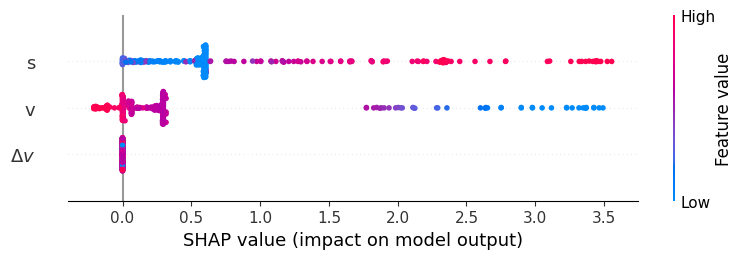

In [55]:
shap.initjs()
%config InlineBackend.figure_format = 'png'
plt.style.use('default')  # 设置画图的风格
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(explainer_xgb_shap_values, X_train, feature_names=featurename, show=True)

##  MLP模型训练和归因

MLPRegressor R-squared (R2): 0.9991605435943715


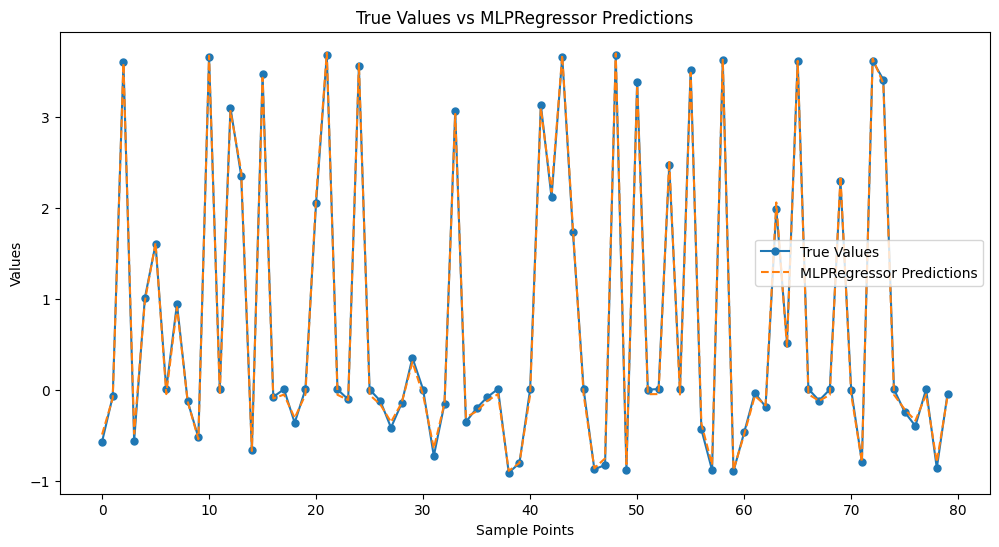

In [56]:
# 创建 Scikit-learn 的 MLPRegressor 模型
from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, random_state=42)

# 训练模型
mlp_reg.fit(X_train, y_train)

# 计算 MLPRegressor 模型的预测输出
mlp_predictions = mlp_reg.predict(X_test)

# 计算 R-squared（R2）来衡量模型准确性
mlp_r2 = r2_score(y_test, mlp_predictions)

print("MLPRegressor R-squared (R2):", mlp_r2)

# 绘制真实值和 MLPRegressor 模型的预测值的曲线对比
plt.figure(figsize=(12, 6))
sample_points = range(len(y_test))
plt.plot(sample_points, y_test, label='True Values', marker='o', markersize=5)
plt.plot(sample_points, mlp_predictions, label='MLPRegressor Predictions', linestyle='--')
plt.xlabel('Sample Points')
plt.ylabel('Values')
plt.legend()
plt.title('True Values vs MLPRegressor Predictions')
plt.show()

In [57]:
import joblib

# 将模型保存到文件
joblib.dump(mlp_reg, 'mlp_regression_model_start.pkl')

['mlp_regression_model_start.pkl']

### 归因（EIDG方法，正定，多基值）

In [58]:
eidg_instance_mlp = EIDG(x_baselines=X_train, model = mlp_reg.predict,steps=5, h=0.1, m=10, pos=True)

In [59]:
explainer_mlp_eidg_values = eidg_instance_mlp.integrated_gradients(X_train)

EIDG运行时间： 0.5959670543670654 秒


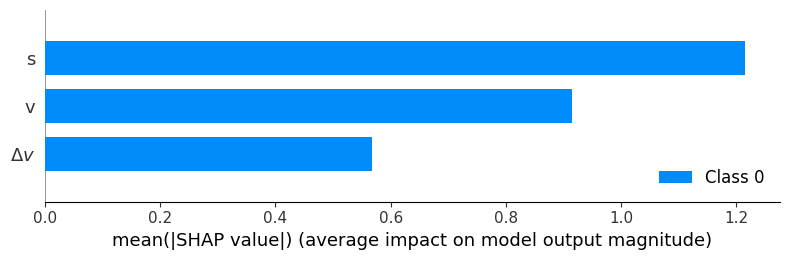

In [60]:
shap.initjs()
%config InlineBackend.figure_format = 'png'
plt.style.use('default')  # 设置画图的风格
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(explainer_mlp_eidg_values, X_train, feature_names=featurename, show=True)

In [61]:
import shap
explainer_mlp = shap.KernelExplainer(mlp_reg.predict, eidg_instance_mlp.x_baselines)

In [62]:
# 计算归因值
explainer_mlp_shap_values = explainer_mlp.shap_values(X_train)

  0%|          | 0/320 [00:00<?, ?it/s]

In [63]:
RS_explainer_mlp = shap.KernelExplainer(mlp_reg.predict, X[20:25,:])
# 计算归因值
RS_explainer_mlp_shap_values = RS_explainer_mlp.shap_values(X_train)

  0%|          | 0/320 [00:00<?, ?it/s]

## 绘制散点图

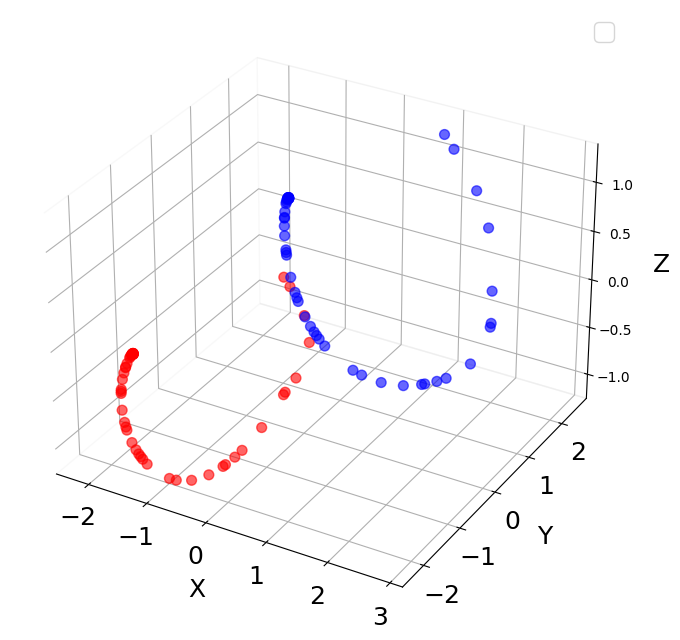

In [64]:
# 根据用户提供的颜色重新绘制向量
# 从图中看，似乎使用了蓝色和红色来区分两组数据
color_group1 = 'blue'  # 第一组颜色
color_group2 = 'red'  # 第二组颜色
fontsize = 18
# 生成两组向量，一组大一组小
large_vectors = explainer_mlp_shap_values[50:100,:]
small_vectors = RS_explainer_mlp_shap_values[50:100,:]
# 创建新的图形和轴对象
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制两组向量，使用圆点
ax.scatter(large_vectors[:, 0], large_vectors[:, 1], large_vectors[:, 2], c=color_group1, marker='o', s=50, label='PS', alpha=0.6)
ax.scatter(small_vectors[:, 0], small_vectors[:, 1], small_vectors[:, 2], c=color_group2, marker='o', s=50, label='RS', alpha=0.6)

# 设置标签和图例
ax.set_xlabel('X', fontsize=fontsize, labelpad=10)
ax.set_ylabel('Y', fontsize=fontsize, labelpad=10)
ax.set_zlabel('Z', fontsize=fontsize, labelpad=10)
ax.legend('',fontsize=fontsize)

plt.xticks(fontname='Arial', fontsize=fontsize)
plt.yticks(fontname='Arial', fontsize=fontsize)


# 设置透明网格
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(True, color='gray', linestyle=':', linewidth=1, alpha=1)  # 轻微透明的网格线

plt.show()

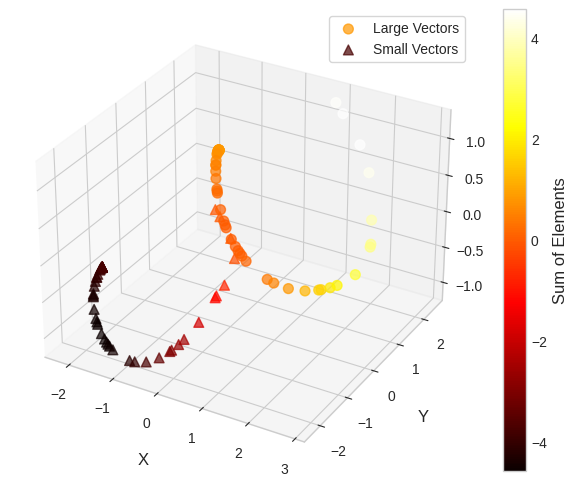

In [65]:
from matplotlib import cm

# 基于您的样式要求重新绘制
plt.style.use('seaborn-whitegrid')  # 设置风格
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 计算每个向量的元素和
sums_large = large_vectors.sum(axis=1)
sums_small = small_vectors.sum(axis=1)

# 根据元素和的大小设置颜色映射
norm = plt.Normalize(min(sums_large.min(), sums_small.min()), max(sums_large.max(), sums_small.max()))
cmap = cm.hot  # 使用热力图颜色映射

# 绘制向量，颜色由元素之和决定
sc1 = ax.scatter(large_vectors[:, 0], large_vectors[:, 1], large_vectors[:, 2], c=sums_large, cmap=cmap, marker='o', s=50, label='Large Vectors', alpha=0.7, norm=norm)
sc2 = ax.scatter(small_vectors[:, 0], small_vectors[:, 1], small_vectors[:, 2], c=sums_small, cmap=cmap, marker='^', s=50, label='Small Vectors', alpha=0.7, norm=norm)

# 设置标签和图例
ax.set_xlabel('X', fontsize=12, labelpad=10)
ax.set_ylabel('Y', fontsize=12, labelpad=10)
ax.set_zlabel('Z', fontsize=12, labelpad=10)
ax.legend(loc='upper right', frameon=True, fontsize=10)

# 添加颜色条
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Sum of Elements', fontsize=12)

plt.show()


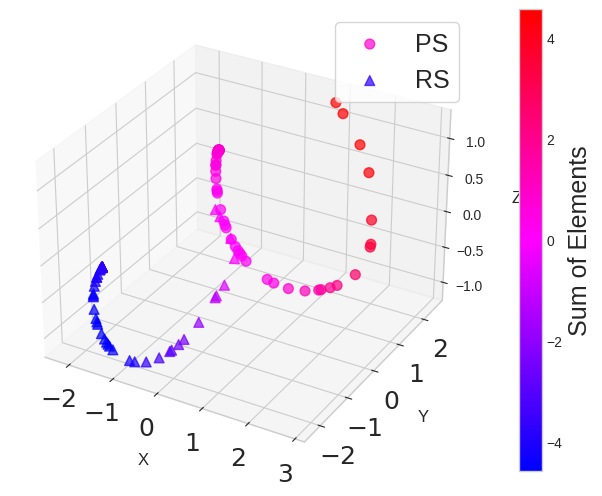

In [66]:
from matplotlib.colors import LinearSegmentedColormap

# 自定义颜色映射
colors = [(0, 0, 1), (0.5, 0, 1), (1, 0, 1), (1, 0, 0.5), (1, 0, 0)]  # 蓝色到红色的渐变
n_bins = 100  # 定义颜色映射中的细分数量
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# 重新绘制图形，使用自定义的颜色映射
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制向量，颜色由自定义的颜色映射决定
sc1 = ax.scatter(large_vectors[:, 0], large_vectors[:, 1], large_vectors[:, 2], c=sums_large, cmap=custom_cmap, marker='o', s=50, label='PS', alpha=0.7, norm=norm)
sc2 = ax.scatter(small_vectors[:, 0], small_vectors[:, 1], small_vectors[:, 2], c=sums_small, cmap=custom_cmap, marker='^', s=50, label='RS', alpha=0.7, norm=norm)

# 设置标签和图例
ax.set_xlabel('X', fontsize=12, labelpad=10)
ax.set_ylabel('Y', fontsize=12, labelpad=10)
ax.set_zlabel('Z', fontsize=12, labelpad=10)
ax.legend(loc='upper right', frameon=True, fontsize=fontsize)

plt.xticks(fontname='Arial', fontsize=fontsize)
plt.yticks(fontname='Arial', fontsize=fontsize)
# 添加颜色条，使用自定义颜色映射
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_cmap), ax=ax)
cbar.set_label('Sum of Elements', fontsize=fontsize)

plt.show()


AssertionError: Feature and SHAP matrices must have the same number of rows!

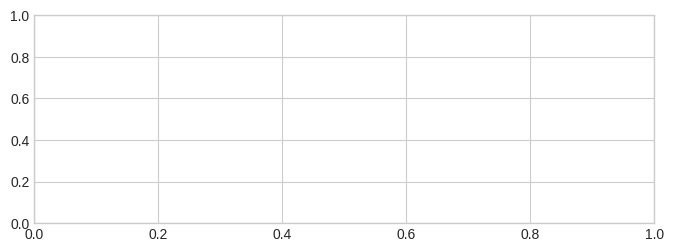

In [67]:
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(explainer_mlp_shap_values, X,feature_names=featurename)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X[:,0],explainer_mlp_shap_values[:,0])

In [ ]:
X[:,0]

In [ ]:
# 创建 Scikit-learn 的 MLPRegressor 模型
from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, random_state=42)

# 训练模型
mlp_reg.fit(X_train, y_train)

# 计算 MLPRegressor 模型的预测输出
mlp_predictions = mlp_reg.predict(X_test)
xgb_predictions = xgb_reg.predict(X_test)
# 计算 R-squared（R2）来衡量模型准确性
mlp_r2 = r2_score(y_test, mlp_predictions)

print("MLPRegressor R-squared (R2):", mlp_r2)

# 绘制真实值和 MLPRegressor 模型的预测值的曲线对比
plt.figure(figsize=(10, 3))
sample_points = range(len(y_test))
plt.plot(sample_points, y_test, label='True Values', marker='o', markersize=5)
plt.plot(sample_points, mlp_predictions, label='MLPRegressor Predictions', marker='*', markersize=5)
plt.plot(sample_points, xgb_predictions, label='xgb_predictions', marker='*', markersize=5)
plt.xlabel('Sample Points')
plt.ylabel('Values')
plt.legend()
plt.title('True Values vs MLPRegressor Predictions')
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
fontsize = 18
# Plot True Values
plt.plot(y_test, label='True Values', marker='o', linestyle='-', color='red', markersize=5)

# Plot MLPRegressor Predictions
plt.plot(mlp_predictions, label='Deep leaning  R2:0.999', marker='*', linestyle='--', color='blue', markersize=5)

# Plot xgb_predictions
plt.plot(xgb_predictions, label='XGBoost R2:0.999', marker='*', linestyle='--', color='green', markersize=5)

# Labels and Title
# Labels and Title
plt.xlabel('Sample points', fontsize=fontsize)
plt.ylabel('a', fontsize=fontsize)
plt.legend(fontsize=fontsize)
# 设置全局的字体大小
plt.rcParams['xtick.labelsize'] = 18 # x轴刻度标签
plt.rcParams['ytick.labelsize'] = 18 # y轴刻度标签
# plt.title('Comparison of True Values with MLPRegressor and xgb_predictions', fontsize=14)
# plt.title('Comparison of True Values with MLPRegressor and xgb_predictions', fontsize=14)
plt.grid(axis='y')  # Show only horizontal gridlines
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
featurename = ["s","v",r"$\Delta v$"]
plt.plot(X[:,0], explainer_xgb_shap_values[:,0])

In [ ]:
featurename = ["s","v",r"$\Delta v$"]
plt.plot(X[:,1], explainer_xgb_shap_values[:,1])

In [ ]:
featurename = ["s","v",r"$\Delta v$"]
plt.plot(X[:,2], explainer_xgb_shap_values[:,2])

In [ ]:
featurename = ["s","v",r"$\Delta v$"]
plt.plot(X[:,0], explainer_mlp_shap_values[:,0])

In [ ]:
featurename = ["s","v",r"$\Delta v$"]
plt.plot(X[:,1], explainer_mlp_shap_values[:,1])

In [ ]:
featurename = ["s","v",r"$\Delta v$"]
plt.plot(X[:,2], explainer_mlp_shap_values[:,2])

In [ ]:
import numpy as np
import time


def numerical_partial_derivative(x_prime, x, model, i, h, k, m):
    """
    Calculate the numerical partial derivative of the model function with respect to input x_i.

    Parameters:
        x (numpy array): Input feature vector.
        model (function): The model function that takes an input x and returns a scalar output F(x).
        i (int): Index of the feature x_i for which to compute the partial derivative.
        h (float): Step size for numerical differentiation.

    Returns:
        partial_derivative (float): Numerical partial derivative for the feature x_i.
    """
    x_plus = x_prime.copy()

    x_plus_h = x_plus + k / m * (x - x_prime)
    x_minus_h = x_plus_h.copy()

    x_plus_h[i] += h

    delta_F = model(x_plus_h) - model(x_minus_h)
    partial_derivative = delta_F / (h)

    return partial_derivative


def integrated_gradients_approx(x, x_primes, model, m=50):
    integrated_gradients = np.zeros_like(x)

    for i in range(len(x)):
        h = 0.01  # 这个增量是自己设计的，是一个参数
        total_integral = 0.0
        for k in range(1, m + 1):
            for x_prime in x_primes:
                # Use numerical_partial_derivative to calculate the partial derivative for each x_prime
                partial_derivative = numerical_partial_derivative(x_prime, x, model, i, h, k, m)
                total_integral += partial_derivative

        integrated_gradients[i] = (x[i] - x_prime[i]) * (total_integral / (m * len(x_primes)))

    return integrated_gradients


# 使用之前训练用的数据集
# 请将下面的代码替换为您之前训练模型时使用的数据集
# 假设您已经有了数据 v、s、delta_v 和 a_v，以及之前训练的 MLP 模型 mlp_reg

# 数据预处理
# X = np.column_stack((v, s, delta_v))
# y = a_v

# 选择 x_prime，从训练数据中选择 top_m 个样本
m = 6  # 选择 6 个样本
model_outputs = mlp_reg.predict(X) # 使用 MLP 模型进行预测

# 找到具有最低模型输出的前 m 个样本的索引
top_m_indices = np.argpartition(model_outputs, m)[:m]

# 选择这些 top m 样本作为 x_prime
x_prime = X[top_m_indices]

# 选择 x_values，从训练数据中选择不在 x_prime 中的所有样本
x_values = X[~np.isin(range(len(X)), top_m_indices)]

In [ ]:
# 计算积分梯度
def model(input_data):
    return mlp_reg.predict([input_data])[0]
ig_values = []
for x_val in x_values:
    ig = integrated_gradients_approx(x_val, x_prime, model, m=50)
    ig_values.append(ig)

In [ ]:
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(np.array(ig_values), x_values,feature_names=featurename)

In [ ]:
ig_mlp_values_array = np.array(ig_values)

fontsize = 20
plt.plot(x_values[:, 0], ig_mlp_values_array[:, 0], linestyle='-', linewidth=2)

# 设置横轴和纵轴标签
plt.xlabel(r's', fontsize=fontsize)  # 设置横轴标签和字体大小
plt.ylabel(r'Attribution value of s', fontsize=fontsize)  # 设置纵轴标签和字体大小

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# 设置线宽
plt.grid(True)

In [ ]:
ig_mlp_values_array = np.array(ig_values)

fontsize = 20
plt.plot(x_values[:, 1], ig_mlp_values_array[:, 1], linestyle='-', linewidth=2)

# 设置横轴和纵轴标签
plt.xlabel(r'v', fontsize=fontsize)  # 设置横轴标签和字体大小
plt.ylabel(r'Attribution value of v', fontsize=fontsize)  # 设置纵轴标签和字体大小

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# 设置线宽
plt.grid(True)

In [ ]:
ig_mlp_values_array = np.array(ig_values)

fontsize = 20
plt.plot(x_values[:, 2], ig_mlp_values_array[:, 2], linestyle='-', linewidth=2)

# 设置横轴和纵轴标签
plt.xlabel(r'$\Delta v$', fontsize=fontsize)  # 设置横轴标签和字体大小
plt.ylabel(r'Attribution value of $\Delta v$', fontsize=fontsize)  # 设置纵轴标签和字体大小

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# 设置线宽
plt.grid(True)

In [ ]:
xgb_reg_ig_values = []
def model(input_data):
    return xgb_reg.predict([input_data])[0]
ig_values = []
for x_val in x_values:
    xgb_reg_ig = integrated_gradients_approx(x_val, x_prime, model, m=50)
    xgb_reg_ig_values.append(xgb_reg_ig)

In [ ]:
array_xgb_reg_ig_values = np.array(xgb_reg_ig_values)

In [ ]:
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(np.array(xgb_reg_ig_values), x_values,feature_names=featurename)

In [ ]:
fontsize = 20
plt.plot(x_values[:, 0], array_xgb_reg_ig_values[:, 0], linestyle='-', linewidth=2)

# 设置横轴和纵轴标签
plt.xlabel(r's', fontsize=fontsize)  # 设置横轴标签和字体大小
plt.ylabel(r'Attribution value of s', fontsize=fontsize)  # 设置纵轴标签和字体大小

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# 设置线宽
plt.grid(True)

In [ ]:
fontsize = 20
plt.plot(x_values[:, 1], array_xgb_reg_ig_values[:, 1], linestyle='-', linewidth=2)

# 设置横轴和纵轴标签
plt.xlabel(r'v', fontsize=fontsize)  # 设置横轴标签和字体大小
plt.ylabel(r'Attribution value of v', fontsize=fontsize)  # 设置纵轴标签和字体大小

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# 设置线宽
plt.grid(True)

In [ ]:
ig_mlp_values_array = np.array(ig_values)

fontsize = 20
plt.plot(x_values[:, 2], array_xgb_reg_ig_values[:, 2], linestyle='-', linewidth=2)

# 设置横轴和纵轴标签
plt.xlabel(r'$\Delta v$', fontsize=fontsize)  # 设置横轴标签和字体大小
plt.ylabel(r'Attribution value of $\Delta v$', fontsize=fontsize)  # 设置纵轴标签和字体大小

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# 设置线宽
plt.grid(True)

In [ ]:
import math
def calculate_acceleration(x):
    # 定义模型参数
    a_max = 4  # 最大加速度，单位：m/s^2
    v0 = 20   # 期望速度，单位：m/s
    T = 1   # 最小时间头距，单位：s
    s0 = 10    # 最小安全距离，单位：m
    delta = 6 # 速度影响因子
    b = 4    # 舒适减速度，单位：m/s^2
    s = x[0]
    v = x[1]
    delta_v = x[2]
    # 计算s_star
    s_star = s0 + max(0, v * T + (v * delta_v) / (2 * math.sqrt(a_max * b)))

    # 计算加速度
    acceleration = a_max * (1 - (v / v0) ** delta - (s_star / s) ** 2)
    return acceleration

In [ ]:
ig_IDM_values = []
for x_val in x_values:
    ig_IDM = integrated_gradients_approx(x_val, x_prime, calculate_acceleration, m=50)
    ig_IDM_values.append(ig_IDM)

In [ ]:
array_ig_IDM_values = np.array(ig_IDM_values)

In [ ]:
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(array_ig_IDM_values, x_values,feature_names=featurename)

In [ ]:
fontsize = 20
plt.plot(x_values[:, 0], array_ig_IDM_values[:, 0], linestyle='-', linewidth=2)

# 设置横轴和纵轴标签
plt.xlabel(r's', fontsize=fontsize)  # 设置横轴标签和字体大小
plt.ylabel(r'Attribution value of s', fontsize=fontsize)  # 设置纵轴标签和字体大小

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# 设置线宽
plt.grid(True)

In [ ]:

fontsize = 20
plt.plot(x_values[:, 1], array_ig_IDM_values[:, 1], linestyle='-', linewidth=2)

# 设置横轴和纵轴标签
plt.xlabel(r'v', fontsize=fontsize)  # 设置横轴标签和字体大小
plt.ylabel(r'Attribution value of v', fontsize=fontsize)  # 设置纵轴标签和字体大小

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# 设置线宽
plt.grid(True)

In [ ]:

fontsize = 20
plt.plot(x_values[:, 2], array_ig_IDM_values[:, 2], linestyle='-', linewidth=2)

# 设置横轴和纵轴标签
plt.xlabel(r'$\Delta v$', fontsize=fontsize)  # 设置横轴标签和字体大小
plt.ylabel(r'Attribution value of $\Delta v$', fontsize=fontsize)  # 设置纵轴标签和字体大小

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# 设置线宽
plt.grid(True)